###### Inicialização

In [1]:
!pip install meteostat yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 12.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from datetime import datetime, date
from IPython.display import Markdown

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)

import seaborn as sns
import plotly.graph_objects as go

from meteostat import Point, Daily

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Análise de Séries temporais (Sessão 4)
---
Pré-processamento (parte 1)


##Transformação de dados

Para realizar uma análise descritiva de séries temporais, devemos procurar:
1. Entender o contexto do problema e da fonte dos dados;
2. Pensar em transformação de dados, para reduzir por exemplo a assimetria dos dados;
3. Investigar a estacionariedade e tentar atingí-la por meio da decomposição dos dados;
4. Ao tornar a série estacionária, devemos partir para analisar a função de autocorrelação;

####Porque transformar dados?

A maioria dos modelos de séries temporais e estimadores estatísticos (média, variância e correlação) são baseados e são mais eficientes com a distribuição normal (ou gaussiana) e as relações lineares entre as variáveis.

##### Propriedades da **distribuição normal**

- sua média, mediana e moda são iguais
- tem forma de sino e é simétrica em torno da média
- a curvatura da distribuição muda em $\mu \pm \sigma$

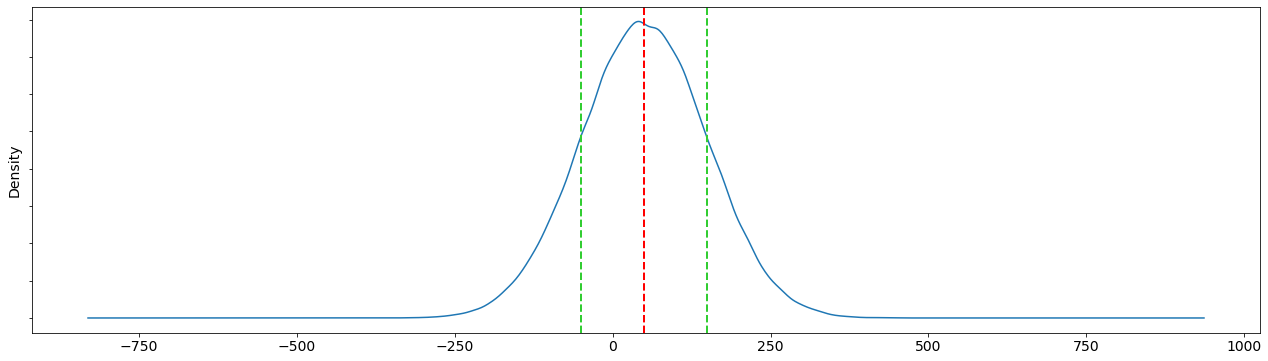

In [4]:
mu = 50
sigma = 100
dist = np.random.randn(100000) * sigma + mu

fig, ax = plt.subplots()
_ = pd.Series(dist).plot(kind='kde', ax=ax)
ax.axvline(mu-sigma, color='limegreen', ls='--', lw=2, label='Mu - Sigma')
ax.axvline(mu, color='red', ls='--', lw=2, label='Mu')
ax.axvline(mu+sigma, color='limegreen', ls='--', lw=2, label='Mu + Sigma')
ax.set_yticklabels([])

plt.show()

##### Função Log
Aplicamos quando:
- A variação cresce com a média
- A distribuição é assimétrica positiva

In [5]:
x = np.arange(0, 10 * np.pi, 0.01)
sintetico = pd.Series(np.sin(x * 4) * x + (2*x))

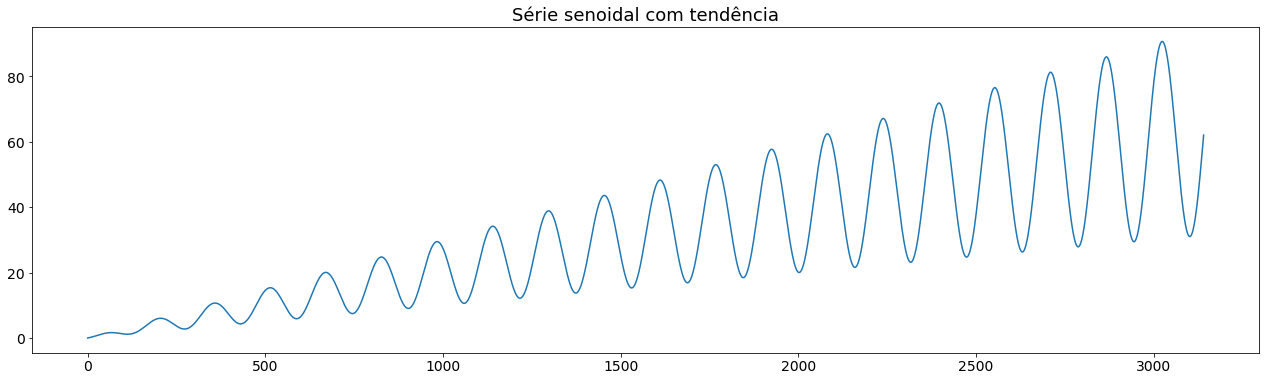

In [6]:
_ = sintetico.plot(kind='line', title="Série senoidal com tendência")

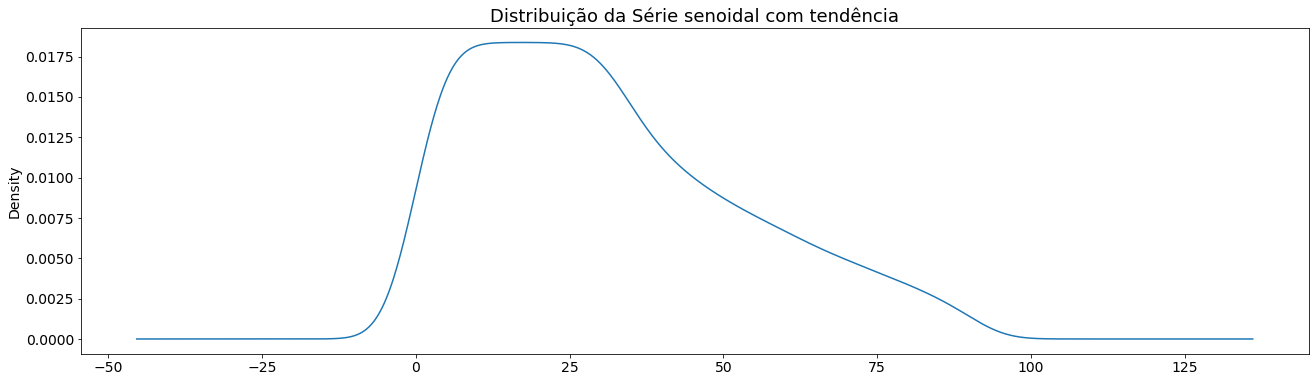

In [7]:
_ = sintetico.plot(kind='kde', title="Distribuição da Série senoidal com tendência")

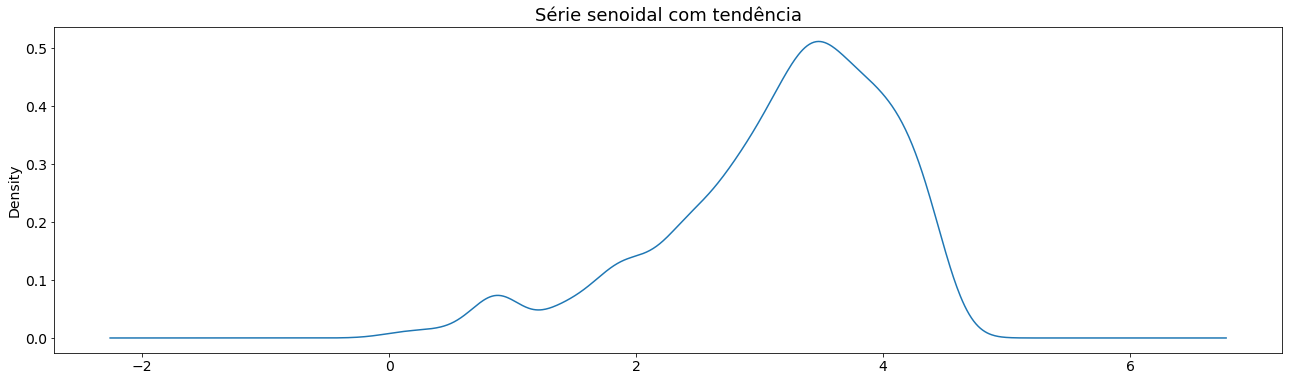

In [8]:
_ = sintetico.apply(np.log1p).plot(kind='kde', title="Série senoidal com tendência")

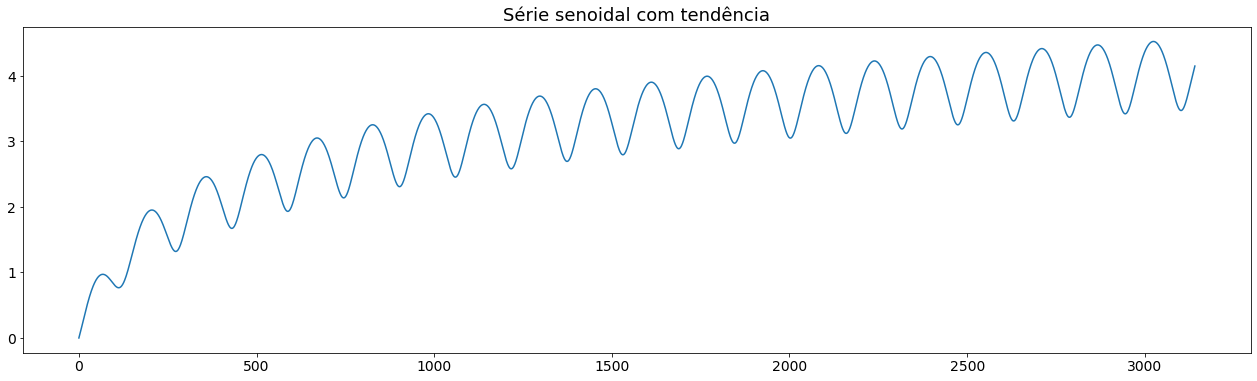

In [9]:
_ = sintetico.apply(np.log1p).plot(kind='line', title="Série senoidal com tendência")

##### Teste de normalidade

O **teste de Shapiro-Wilk** é um teste de hipótese aplicado a uma amostra e cuja hipótese nula é que a amostra foi gerada a partir de uma distribuição normal. Se o valor p for baixo, podemos rejeitar essa hipótese nula e dizer que a amostra não foi gerada a partir de uma distribuição normal.

Sua fórmula é dada por:

\begin{align}
W = \frac{b^2}{s^2} = \frac{\sum_{t=1}^N{(a_t \cdot X_t)^2}}{\sum_{t=1}^N{(X_t - \overline{X_t})^2}}
\end{align}

Onde $X_t$ é a variável aleatória observada e $a_i$ são coeficientes tabelados.

É uma ferramenta estatística bastante fácil de usar que pode nos ajudar a ter uma resposta para a verificação de normalidade que precisamos, mas tem uma falha: não funciona bem com grandes conjuntos de dados.

No entanto, este teste ainda é uma ferramenta muito poderosa que podemos usar, principalmente para séries temporais. Vamos ver um exemplo prático:

- $H_0$ - Nossa hipótese nula - Temos uma distribuicão normal
- $H_1$ - Nossa hipótese alternativa - A distribuição não é normal

In [10]:
def resultado_shapiro(stat, p):
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (stat, p)))
  # interpretando resultados
  alpha = 0.05
  if p > alpha:
      display(Markdown("**A amostra parece Gaussiana (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A amostra não parece Gaussiana (rejeitamos H0)**'))

In [11]:
stat, p = stats.shapiro(sintetico)

resultado_shapiro(stat, p)

Statistics=0.943, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

In [12]:
stat, p = stats.shapiro(sintetico.apply(np.log1p))

resultado_shapiro(stat, p)

Statistics=0.934, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

In [13]:
stat, p = stats.shapiro(dist[:4000])

resultado_shapiro(stat, p)

Statistics=0.999, p-valor=0.22374780

**A amostra parece Gaussiana (falhamos em rejeitar H0)**

### Decomposição

Quando a série possui efeitos de sazonalidade e de tendência, ou seja, não estacionária, precisamos decompor esta série pra capturar estes efeitos.

A decomposição da série permitirá identificar quais componentes estão atuando naquele conjunto em particular, além de possibilitar obter índices e/ou equações para realizar previsões para períodos futuros da série. 

Para representar matematicamente estes efeitos, consideramos:
- $X_t$ - Variável que representa a série temporal. Aquilo que foi medido/observado.
- $T_t$ - Componente de **Tendência** da série
- $S_t$ - Compomente do **efeito sazonal**.
- $R_t$ - Sequência de **variáveis aleatórias** correlacionadas e com média zero.



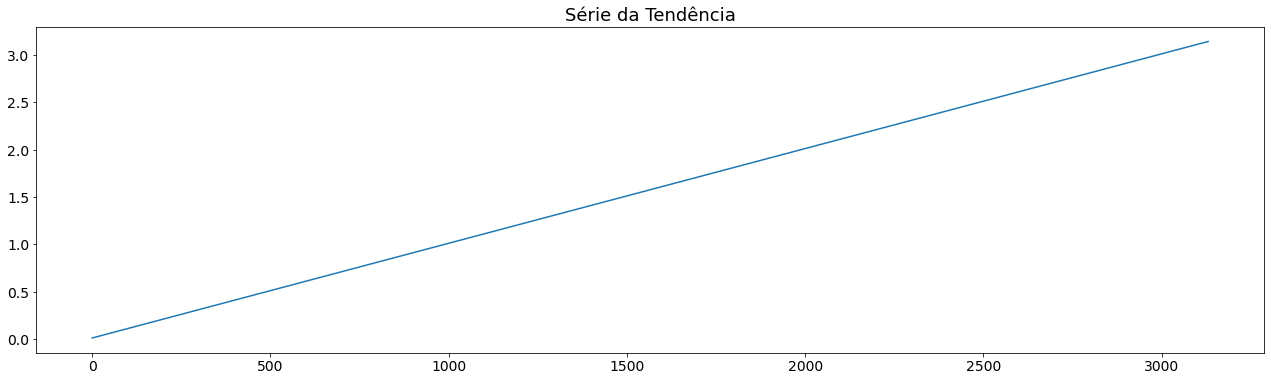

In [14]:
x = np.arange(1, 100 * np.pi, 0.1)
T = pd.Series(x/100)
_ = T.plot(kind='line', title="Série da Tendência")

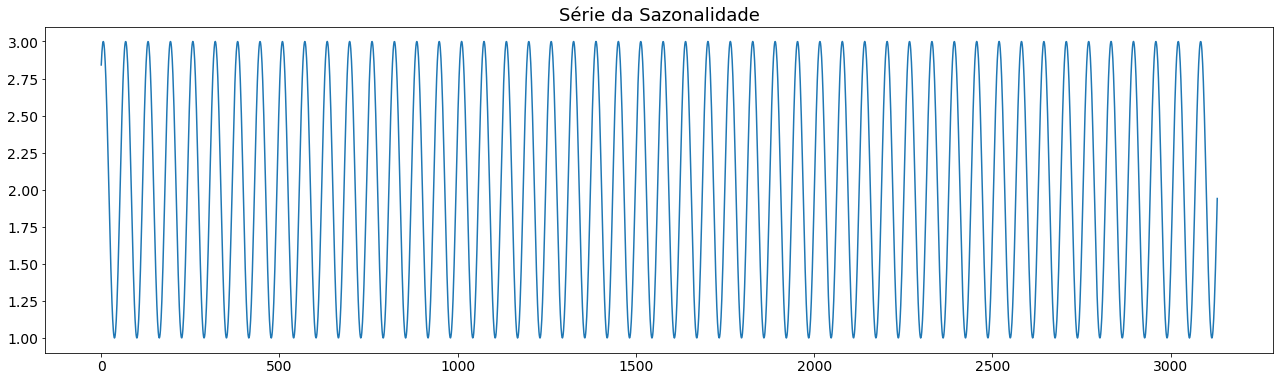

In [15]:
S = pd.Series(np.sin(x)) + 2
_ = S.plot(kind='line', title="Série da Sazonalidade")

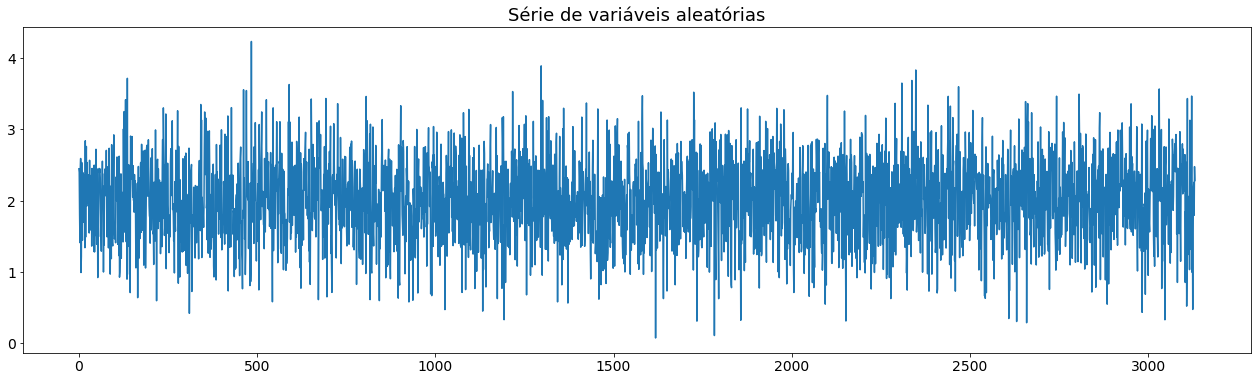

In [20]:
mu = 2
sigma = .6
R =  pd.Series(np.random.randn(len(x)) * sigma + mu)
_ = R.plot(kind='line', title="Série de variáveis aleatórias")

#### 1. Modelo aditivo
O Modelo de Decomposição Aditivo considera que a série temporal é resultante da soma das componentes:
\begin{align}
X_t= T_t + S_t + R_t
\end{align}

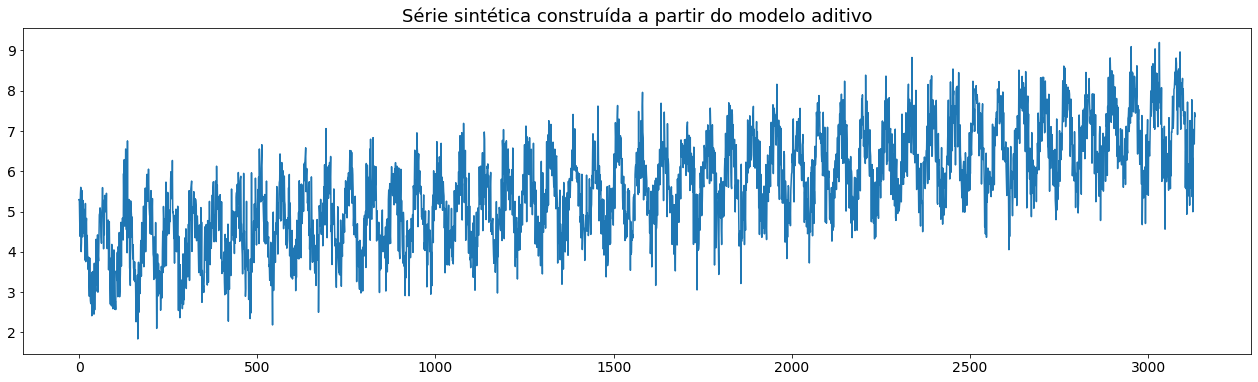

In [21]:
X = T + S + R
_ = X.plot(kind='line', title = "Série sintética construída a partir do modelo aditivo")

#### 2. Modelo Multiplicativo

O Modelo de Decomposição Multiplicativo
considera que a série temporal é resultante do
produto das componentes:

\begin{align}
X_t &= T_t ∙ S_t ∙ R_t \\
\\
\log(X_t) &= \log(T_t∙S_t∙R_t)\\
\\
\log(X_t) &= \log(T_t) + \log(S_t) + \log(R_t)\\
\\
\log(X_t) &= T_t + S_t + R_t
\end{align}

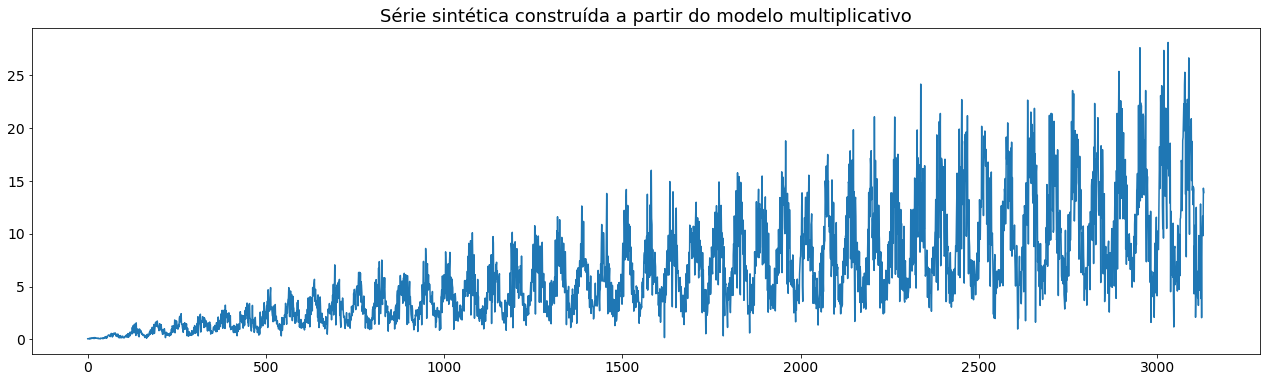

In [22]:
X2 = T * S * R
_ = X2.plot(kind='line', title = "Série sintética construída a partir do modelo multiplicativo")

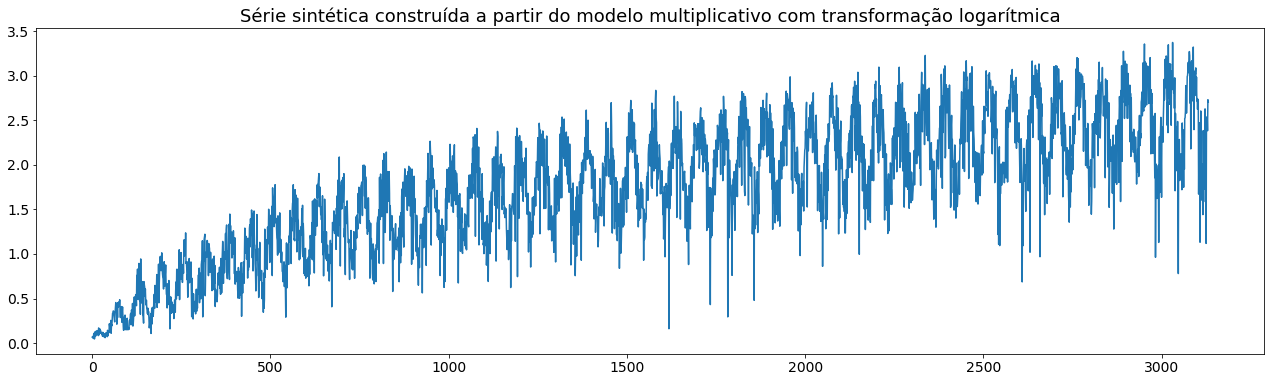

In [23]:
_ = X2.apply(np.log1p).plot(kind='line', title = "Série sintética construída a partir do modelo multiplicativo com transformação logarítmica")

#### 3. Modelo Pseudo-Adtivo

O modelo multiplicativo não pode ser usado quando a série temporal original contém **valores muito pequenos ou zero**. Isso ocorre porque não é possível dividir um número por zero. Nesses casos, consideramos um modelo pseudo aditivo **combinando os elementos dos modelos aditivo e multiplicativo**. Este modelo assume que as variações sazonais e irregulares são dependentes do nível da tendência, mas independentes umas das outras.

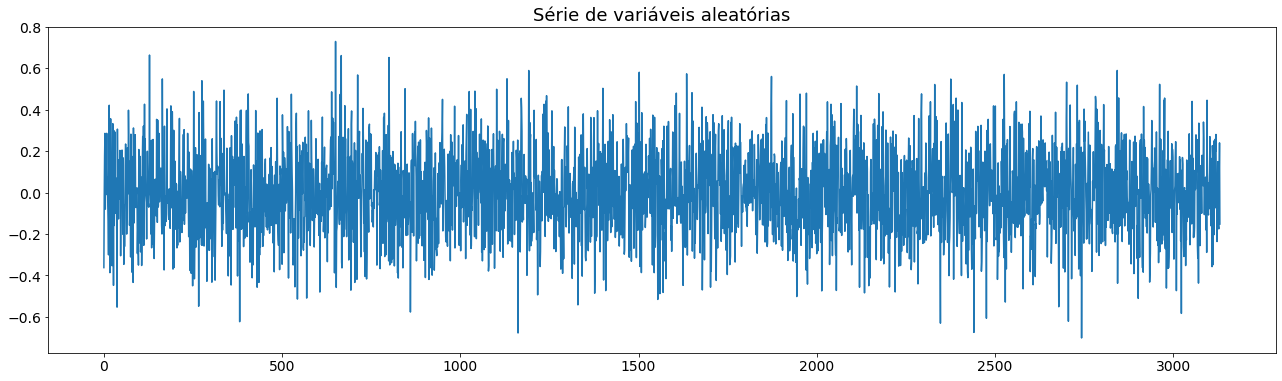

In [24]:
mu = 0
sigma = .2
R2 =  pd.Series(np.random.randn(len(x)) * sigma + mu)
_ = R2.plot(kind='line', title="Série de variáveis aleatórias")

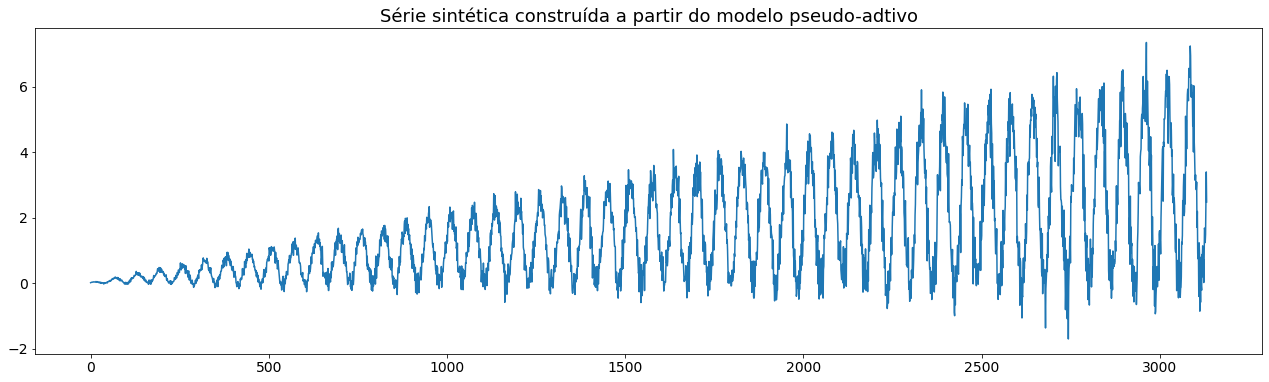

In [25]:
X3 = T * (S + R2 - 1)
_ = X3.plot(kind='line', title = "Série sintética construída a partir do modelo pseudo-adtivo")

### Ferramentas de decomposição

In [26]:
plt.rcParams["figure.figsize"] = (22,12)

In [27]:
start = datetime(2018, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()
serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

#### 1. Aditivo
Decompondo a série de temperaturas de Aracaju através do modelo aditivo.

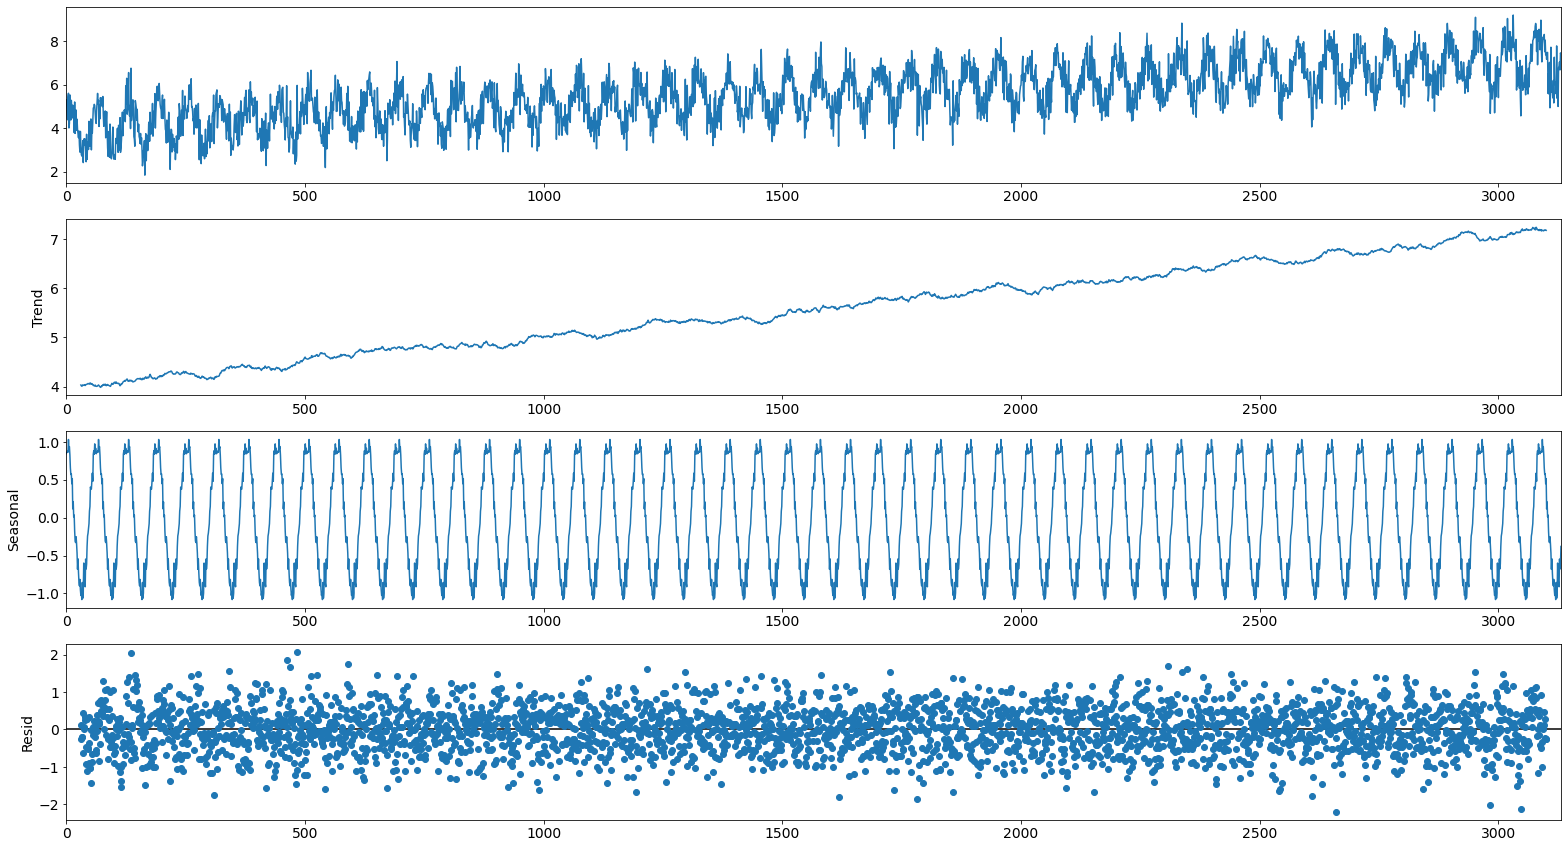

In [28]:
result = sm.tsa.seasonal_decompose(X, model='additive', period=int(2*np.pi*10)+1)
_ = result.plot()

In [29]:
stat, p = stats.shapiro(result.resid.dropna())

resultado_shapiro(stat, p)

Statistics=0.999, p-valor=0.60976571

**A amostra parece Gaussiana (falhamos em rejeitar H0)**

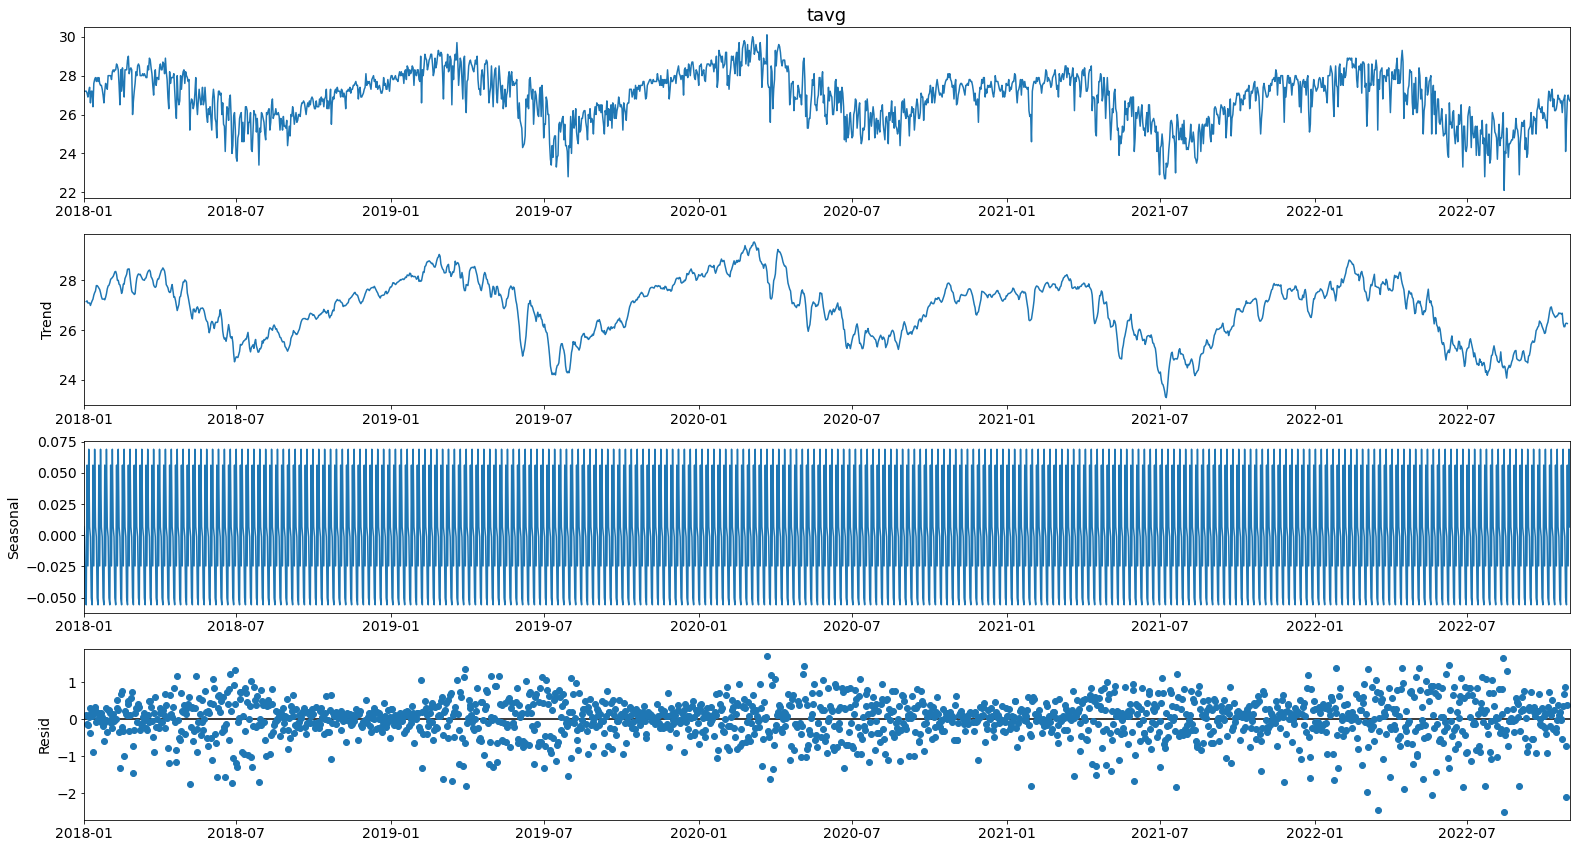

In [30]:
result_add = sm.tsa.seasonal_decompose(serie_aracaju.tavg, model='additive')
_ = result_add.plot()

In [31]:
stat, p = stats.shapiro(result_add.resid.dropna())

resultado_shapiro(stat, p)

Statistics=0.971, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

#### 2. Multiplicativo

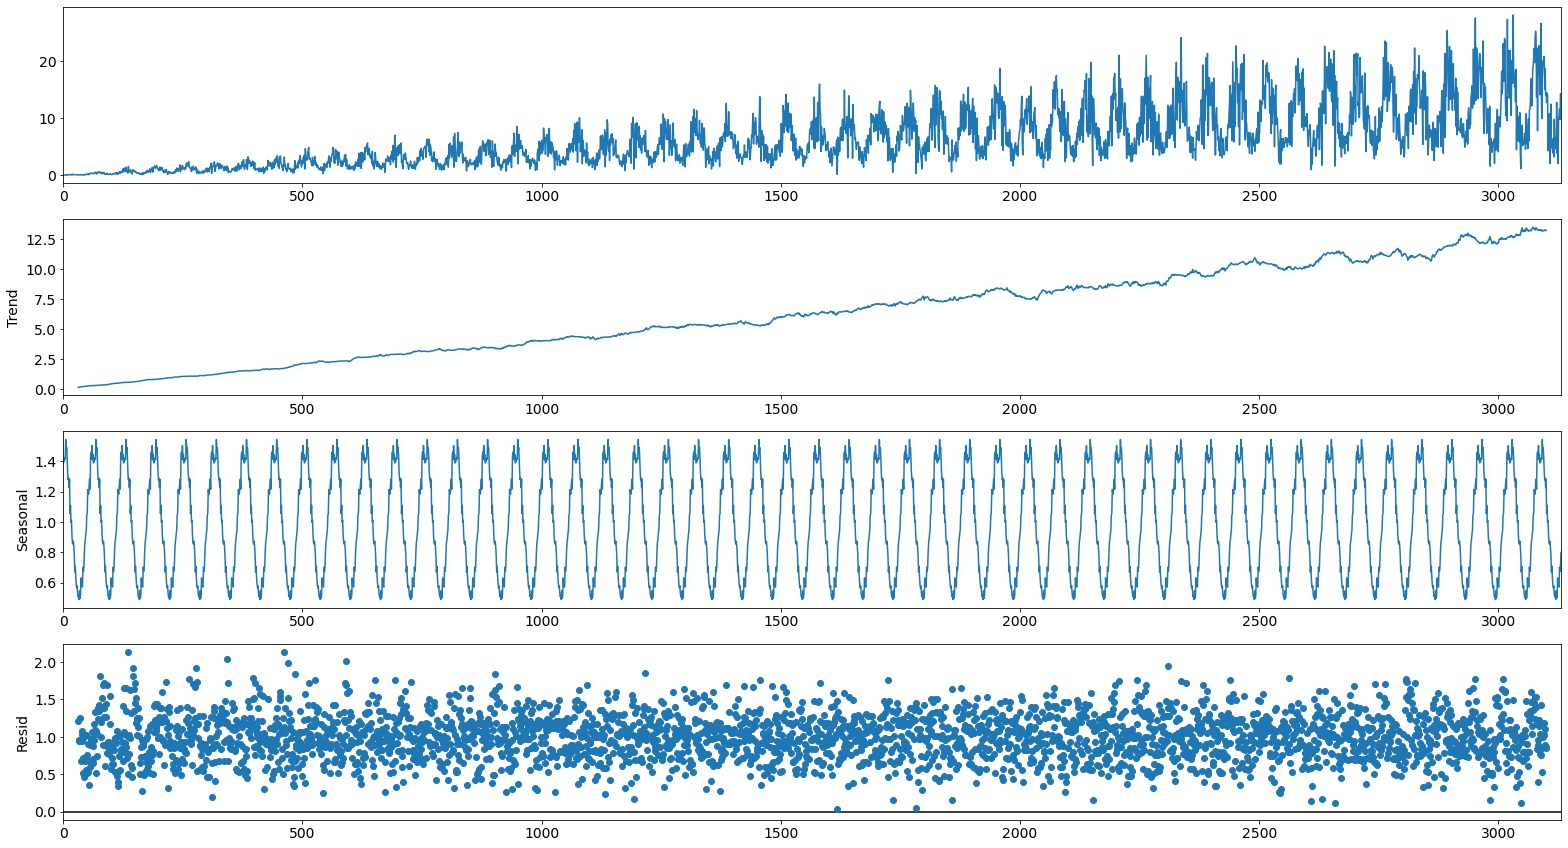

In [32]:
result = sm.tsa.seasonal_decompose(X2, model='multiplicative', period=int(2*np.pi*10)+1)
_ = result.plot()

In [33]:
stat, p = stats.shapiro(result.resid.dropna())

resultado_shapiro(stat, p)

Statistics=0.999, p-valor=0.07208373

**A amostra parece Gaussiana (falhamos em rejeitar H0)**

Aplicando a tranformação logarítmica junto ao modelo aditivo

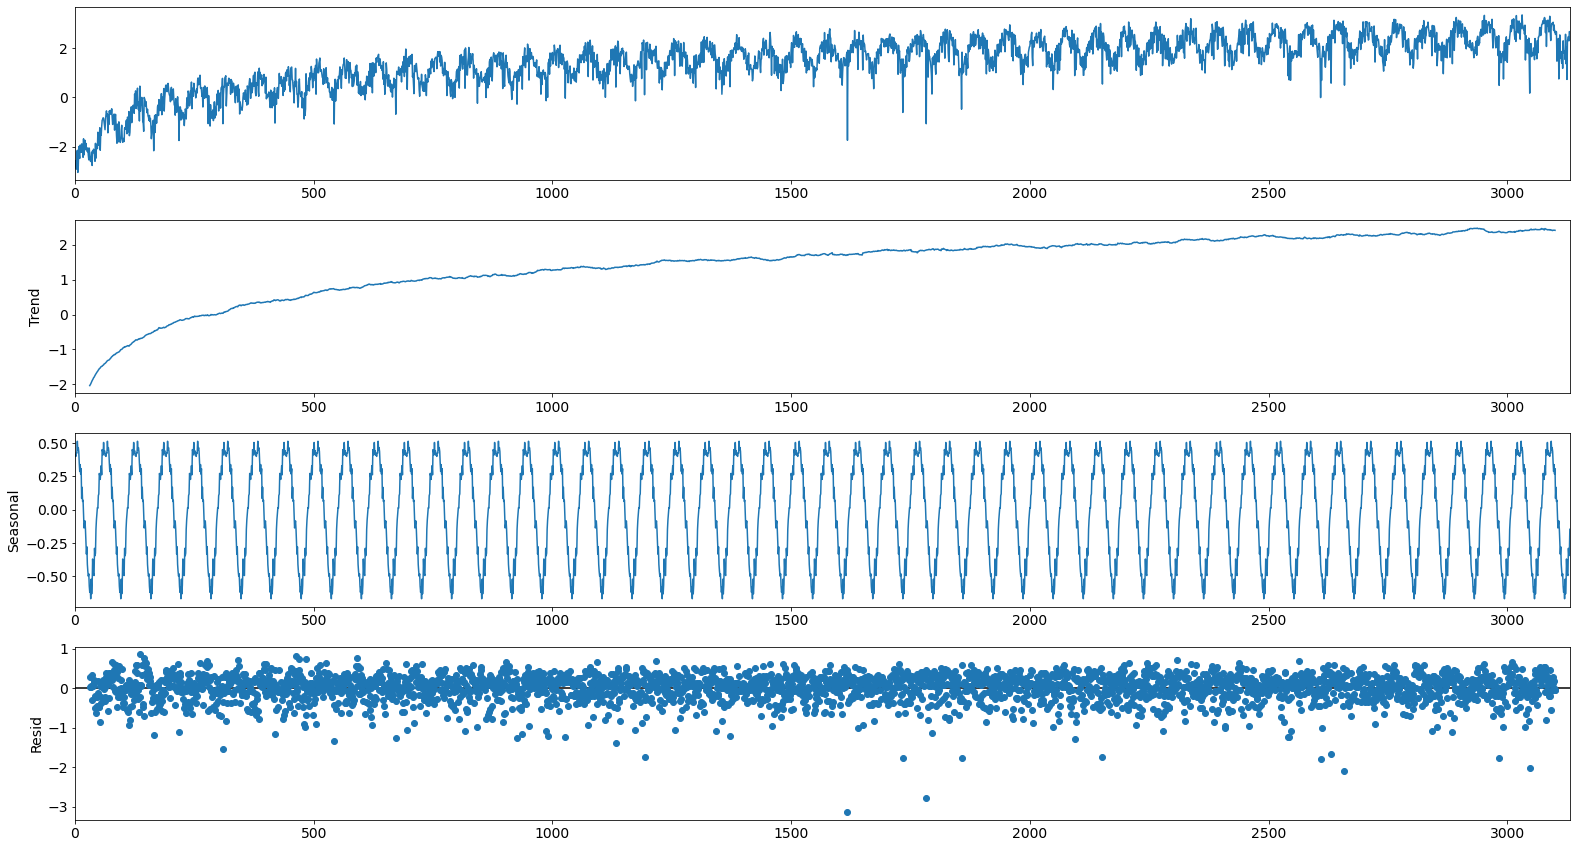

In [34]:
result = sm.tsa.seasonal_decompose(X2.apply(np.log), model='additive', period=int(2*np.pi*10)+1)
_ = result.plot()

In [35]:
stat, p = stats.shapiro(result.resid.dropna())

resultado_shapiro(stat, p)

Statistics=0.930, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

Decompondo a série de temperaturas de Aracaju através do modelo multiplicativo.

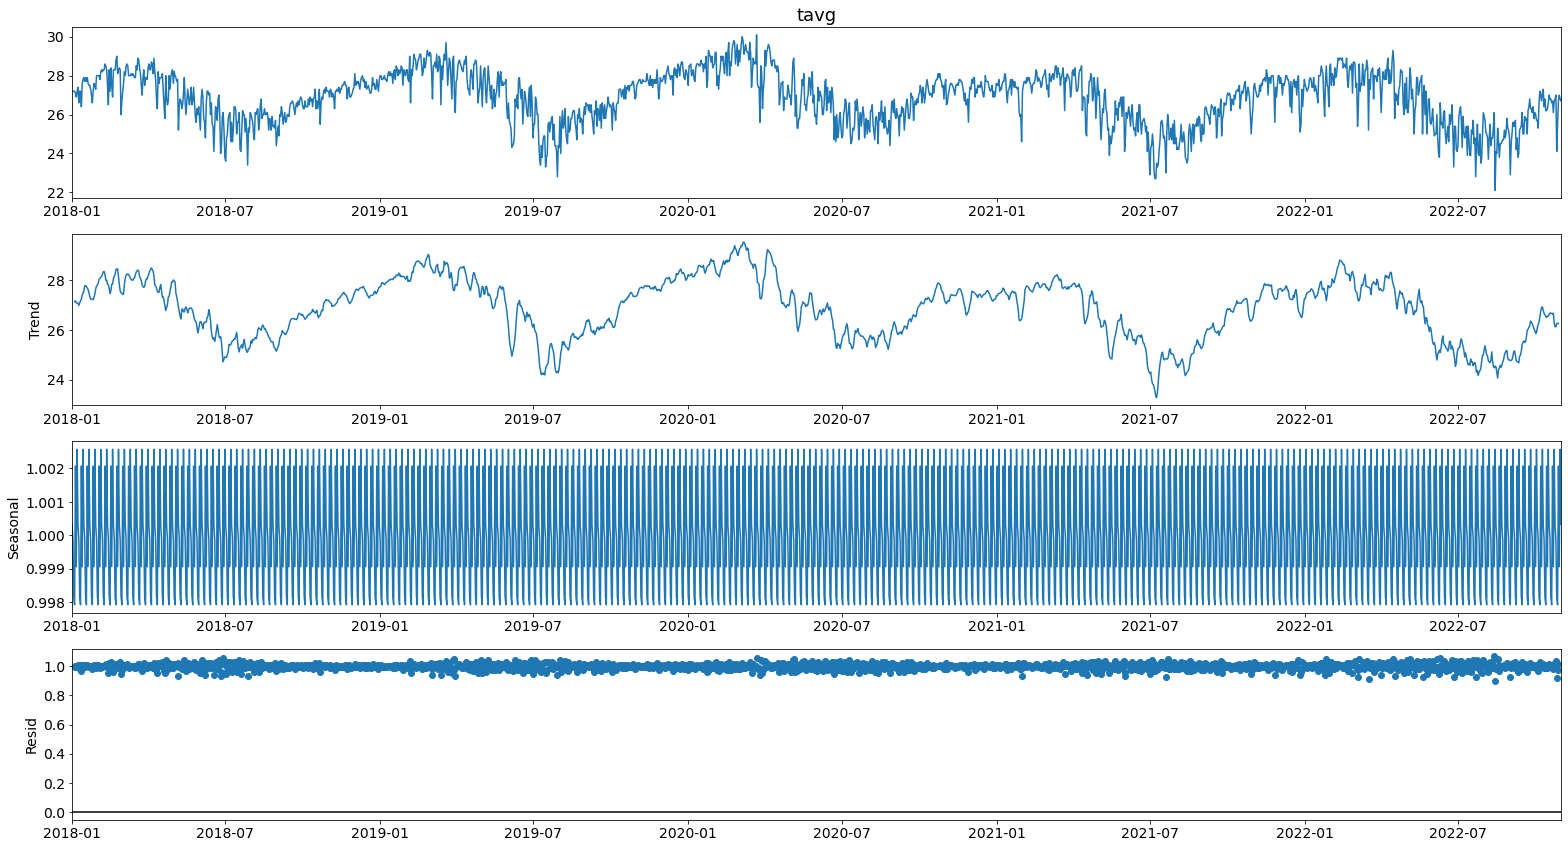

In [36]:
result_mult = sm.tsa.seasonal_decompose(serie_aracaju.tavg, model='multiplicative')
_ = result_mult.plot()

In [37]:
stat, p = stats.shapiro(result_mult.resid.dropna())

resultado_shapiro(stat, p)

Statistics=0.970, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

#### 3. Pseudo-Adtivo

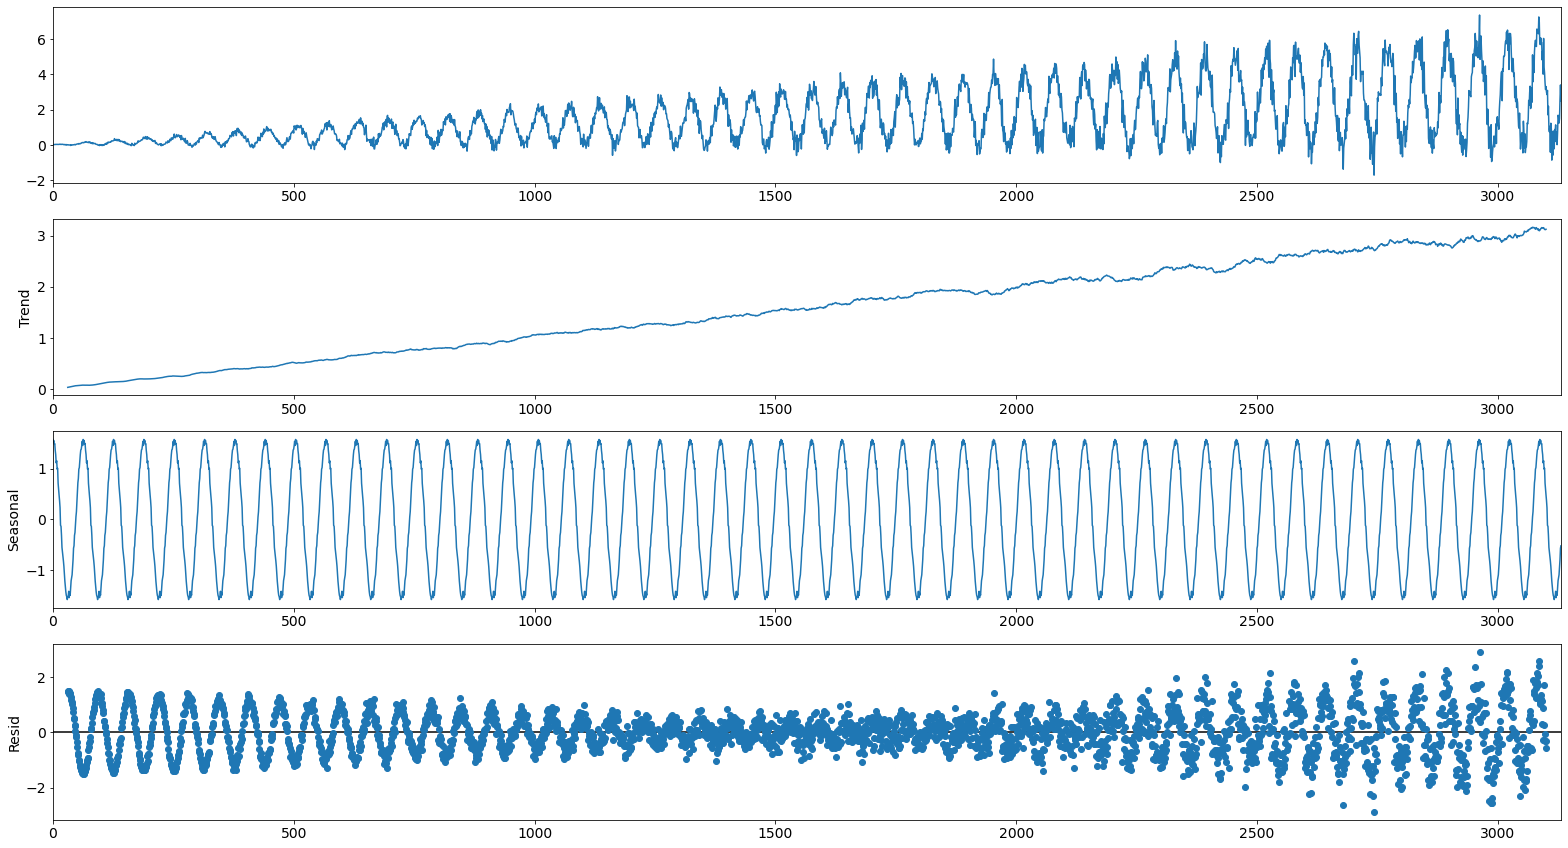

In [40]:
#additive
result = sm.tsa.seasonal_decompose(X3, model='additive', period=int(2*np.pi*10)+1)
_ = result.plot()

In [41]:
stat, p = stats.shapiro(result.resid.dropna())

resultado_shapiro(stat, p)

Statistics=0.999, p-valor=0.54286981

**A amostra parece Gaussiana (falhamos em rejeitar H0)**

### Exercício
1. Decomponha os compomentes de Tendência, Sazonalidade e Ruído da série da temperatura dos últimos 4 anos da sua cidade.
2. Decomponha os compomentes de Tendência, Sazonalidade e Ruído da séries de câmbio dólar/real, euro/real e dólar/yuan chinês.
3. Realize um teste de normalidade (visualmente e usando o teste Shapiro-Wilk) no resíduo extraído das sua séries.